In [ ]:
!python -m spacy download ru_core_news_sm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [3]:
import spacy
import pandas as pd

from tqdm import tqdm
from spacy.tokens import DocBin

nlp = spacy.load('ru_core_news_sm')

In [4]:
neg = pd.read_csv('/content/drive/MyDrive/NLP/negative.csv', encoding="utf8", sep=';', header=None)
pos = pd.read_csv('/content/drive/MyDrive/NLP/positive.csv', encoding="utf8", sep=';', header=None)


## Preprocessing

In [5]:
df = pd.concat([neg, pos], ignore_index=True, sort=False)
df = df.sample(frac=1)  # 0.5 половина данных
df['sentiment'] = df[4]
df['sentiment'] = df['sentiment'].replace(-1, 0)
df['post'] = df[3]
df = df[['post', 'sentiment']]

# /content/drive/MyDrive/NLP/base_config.cfg

In [6]:
df.head(5)

,post,sentiment
36299,народ есть ли аналог расширения All-in-One Sid...,0
221201,Сегодня праздновали мое др с телочками) было к...,1
79265,@marry_bravo а у меня ничего не осталось( ника...,0
127881,@juliarakhimova Это не надолго.Я щас норм обща...,1
190797,"если у тебя есть машина, но нет прав, это не п...",1


#### относительно сбалансированно

In [7]:
df['sentiment'][:170000].value_counts()

1    86008
0    83992
Name: sentiment, dtype: int64

In [8]:
df['sentiment'][170000:].value_counts()

1    28903
0    27931
Name: sentiment, dtype: int64

In [9]:
data = [tuple(df.iloc[i].values) for i in range(df.shape[0])]

In [10]:
data[:5]

[('народ есть ли аналог расширения All-in-One Sidebar  ? В 3.6b5 оно отказывается работать :(',
  0),
 ('Сегодня праздновали мое др с телочками) было круто, люблб вааааас:* http://t.co/9Ybqv0tXlX',
  1),
 ('@marry_bravo а у меня ничего не осталось( никаких салонов,Онли дом!', 0),
 ('@juliarakhimova Это не надолго.Я щас норм общаюсь;)', 1),
 ('если у тебя есть машина, но нет прав, это не повод брать папину тачку без спорса))',
  1)]

In [11]:
train_data = data[:170000]
valid_data = data[170000:]

In [12]:
def make_docs(data):
  """
  this will take a list of texts and labels
  and transform them in spacy documents
  
  """

  docs = []
  # pbar = tqdm(nlp.pipe(data, as_tuples=True), total = len(data))
  for doc, label in tqdm(nlp.pipe(data, as_tuples=True), total = len(data)):
    if label == 0:
      doc.cats['positive'] = 0
      doc.cats['negative'] = 1
    else:
      doc.cats['positive'] = 1
      doc.cats['negative'] = 0
    docs.append(doc)
  return docs


#### отправил все данные

In [13]:
num_texts = 100  # чтобы быстрее, но лучше брать максимальное кол-во данных, которое мы можем прогнать

train_docs = make_docs(train_data)

100%|██████████| 170000/170000 [10:46<00:00, 262.85it/s]


In [14]:
doc_bin = DocBin(docs=train_docs)
doc_bin.to_disk("train.spacy")

valid_docs = make_docs(valid_data)
doc_bin = DocBin(docs=valid_docs)
doc_bin.to_disk("valid.spacy")

100%|██████████| 56834/56834 [03:35<00:00, 263.33it/s]


## Config

In [15]:
!python -m spacy init fill-config /content/drive/MyDrive/NLP/base_config.cfg config.cfg

✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [16]:
# пара вещей с конфига:
# threshold = 0.5 # пороговое значение вероятностb, по тому, что модель может предсказывать категории
# train = 'train.spacy'
# dev = 'valid.spacy' 

# в training разделе
# patience = 1600 терпение в шагах, сколько шагов мы можем потерпеть без улучшений, прежде, чем остановиться
# max_steps = 6000 макс шагов в тренировке
# eval_frequency = 200 размер шага
# там же можно поставить dropout
# на gpu не тренирует, судя по сайту, для использования gpu в spacy надо тренировать трансформер --gpu-id 0


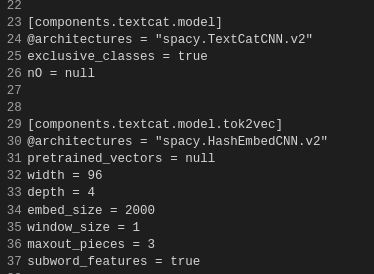

## Train

#### Ограничил 6000 шагами, либо 1600 patience

In [19]:
! python -m spacy train config.cfg --output ./output


ℹ Saving to output directory: output
ℹ Using CPU
ℹ To switch to GPU 0, use the option: --gpu-id 0

=========================== Initializing pipeline ===========================
[2022-10-27 06:23:36,959] [INFO] Set up nlp object from config
INFO:spacy:Set up nlp object from config
[2022-10-27 06:23:36,978] [INFO] Pipeline: ['textcat']
INFO:spacy:Pipeline: ['textcat']
[2022-10-27 06:23:36,984] [INFO] Created vocabulary
INFO:spacy:Created vocabulary
[2022-10-27 06:23:36,986] [INFO] Finished initializing nlp object
INFO:spacy:Finished initializing nlp object
[2022-10-27 06:25:07,689] [INFO] Initialized pipeline components: ['textcat']
INFO:spacy:Initialized pipeline components: ['textcat']
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['textcat']
ℹ Initial learn rate: 0.001
E    #       LOSS TEXTCAT  CATS_SCORE  SCORE 
---  ------  ------------  ----------  ------
  0       0          0.25       45.91    0.46
  0     200  

In [20]:
!cp -r output/ /content/drive/MyDrive/NLP/spacy/cnnoutput 

## Inference

#### Возьмем немного первых попавшихся записей с Твиттера

In [23]:
# load thebest model from training
nlp = spacy.load("output/model-best")
text = ""
print("type : ‘quit’ to exit")
# predict the sentiment until someone writes quit
while text != "quit":
    text = input("Please enter example input: ")
    doc = nlp(text)
    print(doc.cats)
    if doc.cats['positive'] >.5:
        print(f"the sentiment is positive")
    else:
        print(f"the sentiment is negative")

type : ‘quit’ to exit
Please enter example input: Без религии страна обойтись может. Без образования и науки она умрет.
{'positive': 0.00989675521850586, 'negative': 0.9901032447814941}
the sentiment is negative
Please enter example input: Они держатся за руки Я ПОВТОРЯЮ ОНИ ДЕРЖАТСЯ ЗА РУКИ
{'positive': 0.8839454650878906, 'negative': 0.11605455726385117}
the sentiment is positive
Please enter example input: мои фламандские коллеги занимаются отрицанием и произносят Neg как Нехь
{'positive': 0.15724621713161469, 'negative': 0.8427538275718689}
the sentiment is negative
Please enter example input: мне пытались объяснить что даже асексуалом можно быть бисексуалом короче я совсем запуталась я плесень в чашке петри все эти ориентации и гендеры не про меня
{'positive': 0.05416664108633995, 'negative': 0.9458333253860474}
the sentiment is negative
Please enter example input: Дочка всего вторую неделю школьница, а я уже оказалась в шутке, где в 20:00 выясняется, что завтра в школу надо прине

## Only inference
загрузка обученной модели с диска



In [ ]:
!python -m spacy download ru_core_news_sm
from google.colab import drive
drive.mount('/content/drive')
import spacy
import pandas as pd

from tqdm import tqdm
from spacy.tokens import DocBin

nlp = spacy.load('ru_core_news_sm')

In [ ]:
# load thebest model from training
nlp = spacy.load("/content/drive/MyDrive/NLP/spacy/cnnoutput/model-last")
text = ""
print("type : ‘quit’ to exit")
# predict the sentiment until someone writes quit
while text != "quit":
    text = input("Please enter example input: ")
    doc = nlp(text)
    print(doc.cats)
    if doc.cats['positive'] >.5:
        print(f"the sentiment is positive")
    else:
        print(f"the sentiment is negative")